# Computing Lyapunov exponents of Lorenz system
This script computes the Lyapunov exponents of the Lorenz system from one dimensional time series data sampled from a Lorenz system. First, the optimal embedding parameters are choosen. Then the data is embedded using time delay and PCA. On this embedded data the Lyapunov spectrum is estimated using an iterative algorithm as well as linear regression to approximate the value of the Jacobian.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

## Simulating the system

In [2]:
#parameters of the system
rho = 45.92
sigma = 16
beta = 4

#Initial condition
state0 = np.array([-8, -8, 27])

def difeq(data,t):
    '''System of differential eqautions'''
    x,y,z=data
    xp=sigma*(y-x)
    yp=x*(rho-z)-y
    zp=x*y-beta*z
    return [xp,yp,zp]

In [3]:
dt=0.01
T=10000
discard_t = 100
T_total = T+discard_t
t=np.arange(0,T_total,dt)
data=integrate.odeint(difeq,state0,t)[int(discard_t/dt):]
N=len(data)
#Data along X
Xdata=data[:,0]
varx=np.var(Xdata)
noise=0.005
Xdata+=np.random.normal(0,noise*varx,len(Xdata))

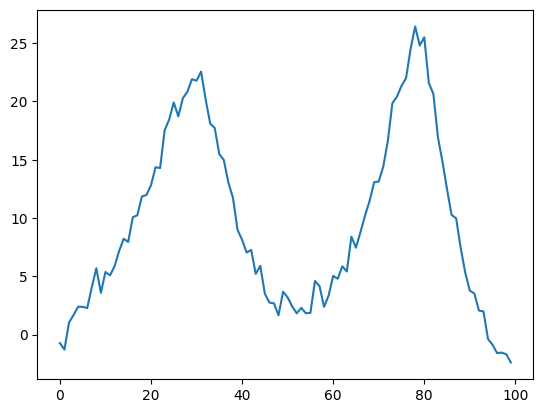

In [39]:
plt.figure()
plt.plot(Xdata[0:100])

## Embed time series data 


In [4]:
def getLag(tseries,m,tau=1):
    '''Input: Lag step tau ( = distance between lags),
    m = dimension of lag vector, tseries = time series data'''
    lengthY=tseries.shape[0]
    Ncolumns=m
    Nrows=math.ceil(lengthY/tau)-Ncolumns+1
    x=np.zeros([Nrows,Ncolumns])
    for k in range(Nrows):
        #Constructing the lag vector 
        xk=tseries[tau*k::tau]
        
        #Broadcasting them into same shape
        xk=np.array(xk[0:Ncolumns])
        x[k,:]=xk
    return x

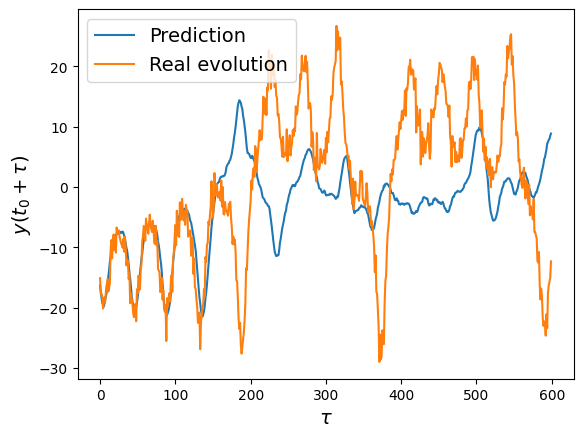

In [31]:
predictedevolution=[]
#Point at which we predict
p0=300

#Dimension of the timeseries
dimtimeseries=1

#Value of K
K=18
m=3


#Number of nearest neighbours included in computations
Np=8

X=getLag(Xdata,K)
#Subtracting the mean of each column
Xmean=X.mean(axis=0)
X_m = X-Xmean
#Covariance matrix of dimension k*k, already normalized
cov = np.cov(X_m.T)
#Diagonalizing the covariance matrix
eigvals,eigvecs = np.linalg.eig(cov)

#Projecting onto principal components
XPCA= X.dot(eigvecs[:,:m])
Steps=len(XPCA)
taumax=600
#Computing distance in reconstructed phase space and keeping Nearest neigbhours
disttoxt=np.sqrt(np.sum(np.square((XPCA[:-taumax]-XPCA[p0])),axis=1))

#Excluding nearest neighbours in time
disttoxt[p0-20:p0+20]=np.Inf

#Keeping only clostest points
sort_index = np.argsort(disttoxt)   

for tau in np.arange(0,taumax):
    #Make sure evolved points are in time series
    indevolved=sort_index+tau
    sel=indevolved<Steps
    indevolved=indevolved[sel]

    #Keeping Np closest neigbours
    indevolved=indevolved[0:Np]

    NearNeighbourst=XPCA[indevolved-tau]
    #Evolved nearest neighbours
    NearNeighbourstnew=XPCA[indevolved]
    #Average over the evolved Nearest neighbours
    xtnew=np.mean(NearNeighbourstnew,axis=0)
    #Go back to real space
    Realspace=xtnew.dot(eigvecs[:,:m].T)
    Realspace=Realspace[0:dimtimeseries]
    predictedevolution.append(Realspace)  

direction=0
fig=plt.figure()
plt.plot(np.arange(0,tau+1),np.array(predictedevolution)[:,0],label='Prediction')
plt.plot(np.arange(0,tau+1),data[p0:p0+tau+1,0],label='Real evolution')
plt.legend(fontsize=14)
plt.xlabel(r'$\tau$',fontsize=14)
plt.ylabel(r'$y(t_0+\tau)$',fontsize=14)
fig.savefig('PredictabilityIllustration.png', format='png', dpi=1200)
plt.show()


### Maximize predictability to find optimal value of K, m
Predictions are made in the following way: In the delay embedding space, close neighbours in space (not successive points in time) are identified. The Np closest neighbours of a point at time t0 of the time series are taken and their value at a later time t0+tau is evaluated. Going back to observation space allows to evaluate the quality of the prediction.

The following two functions (linear_fit and prediction_time) are by Antonio Costa

In [5]:
def linear_fit(x,y):
    reg = LinearRegression().fit(x.reshape(-1,1), y)
    r2 = reg.score(x.reshape(-1,1),y)
    m = reg.coef_
    b = reg.intercept_
    return r2,m,b

def prediction_time(mean_distance,n_iters=20):
    tau0 = np.random.randint(int(len(mean_distance)*.05),int(.95*len(mean_distance)))
    es0=mean_distance[tau0]
    intE = np.cumsum(mean_distance)
    len_dist = len(mean_distance)
    x,y = np.arange(tau0,len(mean_distance)),intE[tau0:len(mean_distance)]
    r2,new_es,A = linear_fit(x,y)
    new_tau= np.arange(len(mean_distance))[mean_distance>new_es][0]
    Tpreds = [-A/new_es,]
    r2s=[r2,]
    es = [new_es,]
    for k in range(n_iters):
        x,y = np.arange(new_tau,len(mean_distance)),intE[new_tau:len(mean_distance)]
        r2,new_es,A = linear_fit(x,y)
        new_tau= np.arange(len(mean_distance))[mean_distance>new_es][0]
        Tpreds.append(-A/new_es)
        r2s.append(r2)
        if np.abs(new_es-es[-1])<1e-8:
            break
        es.append(new_es)
    return r2s,np.hstack(Tpreds)


#### Finding optimal value of number nearest neighbours

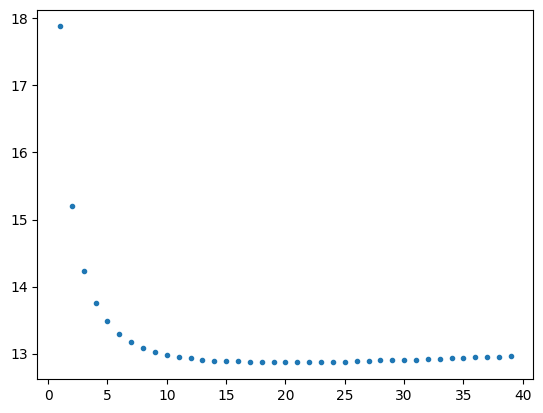

In [34]:
#Dimension of the timeseries
dimtimeseries=1
K=25

Lagmat=getLag(Xdata,K)


#Average over t'
points=np.random.choice(np.arange(int(len(Xdata)/2)),size=500, replace=False)

Npmax=40
#Storing the Nearest neighbour positions
NNIndices=np.zeros((len(points),Npmax),dtype=int)
for kp,p0 in enumerate(points):
    disttoxt=np.sqrt(np.sum(np.square((Lagmat[:-1]-Lagmat[p0])),axis=1))
    #Excluding nearest neighbours in time
    disttoxt[p0-20:p0+20]=np.Inf
    #Keeping only clostest points
    sort_index = np.argsort(disttoxt)   
    NNIndices[kp] = sort_index[:Npmax]

#Compute one step prediction error in reconstructed space
eps_Np = np.zeros((Npmax-1,len(points)))
Np_range = np.arange(1,Npmax)

for kn,Np in enumerate(Np_range):
    for kp,p0 in enumerate(points):
        pred = np.mean(Lagmat[NNIndices[kp][:Np]+1],axis=0)
        eps_Np[kn,kp] = np.linalg.norm(pred-Lagmat[p0+1])
        
plt.figure()
plt.plot(Np_range,eps_Np.mean(axis=1),'.');

In [35]:
minval=(eps_Np.mean(axis=1)).min()
posmin=list(eps_Np.mean(axis=1)).index(minval)
Np=Np_range[posmin]
print(Np)

21


#### Finding optimal value of K (dimension of time delay matrix)


2
4
6
8


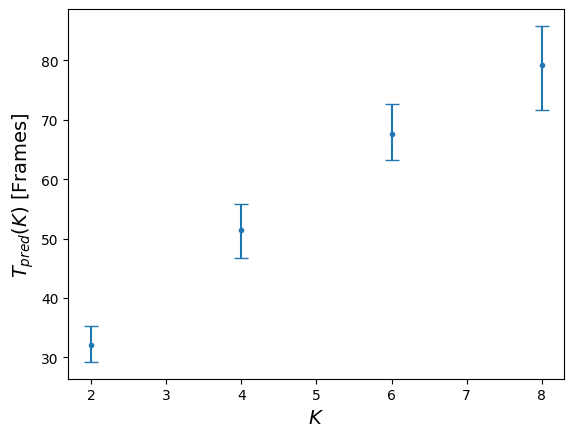

In [8]:
#Dimension of the timeseries
dimtimeseries=1

#K values
Krange=np.arange(2,10,2)

#Number of nearest neighbours
Np=15

pointsaverage=500

#Prediction time
Tpred=np.zeros((len(Krange),3))

#Average over t'
points=np.random.choice(np.arange(int(len(Xdata)/2)),size=pointsaverage, replace=False)

#Average over tau
taumax=800
taurange=np.arange(0,taumax)

for k,K in enumerate(Krange):
    print(K)
    Lagmat=getLag(Xdata,K)
    #Indices of Nb nearest neighbours for each point in points
    NNIndices=np.zeros((len(points),Np),dtype=int)

    for kp,p0 in enumerate(points):
        disttoxt=np.sqrt(np.sum(np.square((Lagmat[:-taumax]-Lagmat[p0])),axis=1))
        #Excluding nearest neighbours in time
        disttoxt[p0-20:p0+20]=np.Inf

        #Keeping only Np nearest neighbours for each point
        sort_index = np.argsort(disttoxt)  
        NNIndices[kp]=sort_index[:Np]

    #Computing the error for different values of tau and for each point
    eps_p = np.zeros((len(points),taumax))
    for kp in range(len(points)):
        #Evolved nearest neighbours
        NearNeighbourstnew=[Lagmat[NNIndices[kp,kn]:NNIndices[kp,kn]+taumax] for kn in range(Np)]
        Xpred = np.mean(NearNeighbourstnew,axis=0)
        eps_p[kp] = np.sqrt((Xpred[:,-1]-Lagmat[points[kp]:points[kp]+taumax,-1])**2)

    Etau = np.mean(eps_p,axis=0)
    A,B=prediction_time(Etau,n_iters=20)
    mean = B[-1]
    
    #Bootstrapping for errorbars
    n_boot = 100
    Tpred_boot = np.zeros(n_boot)
    for kb in range(n_boot):
        Etau = eps_p[np.random.randint(0,len(eps_p),len(eps_p))].mean(axis=0)
        A,B=prediction_time(Etau,n_iters=20)
        Tpred_boot[kb] = B[-1]
    cil = np.percentile(Tpred_boot,2.5)
    ciu = np.percentile(Tpred_boot,97.5)
    Tpred[k] = [mean,cil,ciu]
    

fig=plt.figure()
plt.errorbar(Krange,Tpred[:,0],yerr = [Tpred[:,0]-Tpred[:,1],Tpred[:,2]-Tpred[:,0]],capsize=5,fmt='.')
plt.xlabel(r'$K$',fontsize=14)
plt.ylabel(r'$T_{pred}(K)$'+' [Frames]',fontsize=14)
name='Koptim_noise='+str(noise)+'_NN='+str(Np)+'_K='+str(K)+'_Averagepoints='+str(pointsaverage)+'.png'
fig.savefig(name, format='png', dpi=1200)
plt.show()

In [23]:
max=Tpred.max()
posmax=list(Tpred).index(max)
K=Krange[posmax]
print(K)

98


#### Finding optimal value of m 

1
2
3
4
5
6


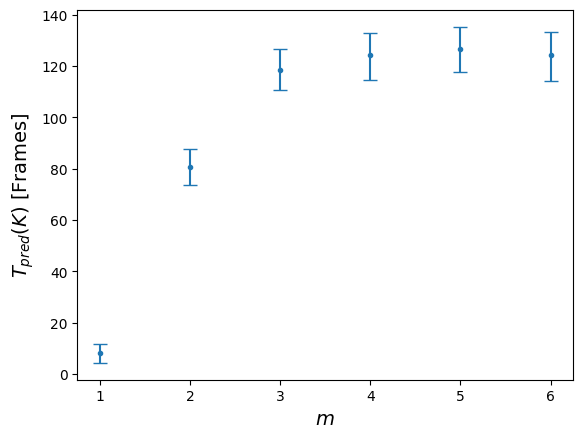

In [13]:
#Dimension of the timeseries
dimtimeseries=1

pointsaverage=250
#Average over t'
points=np.random.choice(np.arange(int(len(Xdata)/2)),size=pointsaverage, replace=False)

#Average over tau
taumax=1000
K=25
#Constructing covariance matrix
Lagmat=getLag(Xdata,K)
Xm = Lagmat-Lagmat.mean(axis=0)
cov = np.cov(Xm.T)
eigvals,eigvecs = np.linalg.eig(cov)

#Tpred for different values of m
mrange = np.arange(1,7)
Tpred=np.zeros((len(mrange),3))


for km,m in enumerate(mrange):
    print(m)
    #Projecting onto PCA
    XPCA= Lagmat.dot(eigvecs[:,:m])

    #Getting nearest nearest neighbours
    NNIndices=np.zeros((len(points),Np),dtype=int)
    for kp,p0 in enumerate(points):
        disttoxt=np.sqrt(np.sum(np.square((XPCA[:-taumax]-XPCA[p0])),axis=1))
        #Excluding nearest neighbours in time
        disttoxt[p0-20:p0+20]=np.Inf
        #Keeping only clostest points
        sort_index = np.argsort(disttoxt)   
        NNIndices[kp] = sort_index[:Np]
    
    eps_p = np.zeros((len(points),taumax))  
    
    for kp in range(len(points)):
        #Predicting evolution in reconstructed space
        NearNeighbourstnew=[XPCA[NNIndices[kp,kn]:NNIndices[kp,kn]+taumax] for kn in range(Np)]
        XPCA_pred = np.mean(NearNeighbourstnew,axis=0)
        #Going back to realspace
        Xpred = XPCA_pred.dot(eigvecs[:,:m].T)
        #Computing the prediction error
        eps_p[kp] = np.sqrt((Xpred[:,-1]-Lagmat[points[kp]:points[kp]+taumax,-1])**2)
    
    Etau = np.mean(eps_p,axis=0)
    A,B=prediction_time(Etau,n_iters=20)
    mean = B[-1]        
    
    #Bootstrapping for errorbars
    n_boot = 100
    Tpred_boot = np.zeros(n_boot)
    for kb in range(n_boot):
        Etau = eps_p[np.random.randint(0,len(eps_p),len(eps_p))].mean(axis=0)
        A,B=prediction_time(Etau,n_iters=20)
        Tpred_boot[kb] = B[-1]
    cil = np.percentile(Tpred_boot,2.5)
    ciu = np.percentile(Tpred_boot,97.5)
    Tpred[km] = [mean,cil,ciu]

fig=plt.figure()
plt.errorbar(mrange,Tpred[:,0],yerr = [Tpred[:,0]-Tpred[:,1],Tpred[:,2]-Tpred[:,0]],capsize=5,fmt='.')
plt.xlabel(r'$m$',fontsize=14)
plt.ylabel(r'$T_{pred}(K)$'+' [Frames]',fontsize=14)
name='moptim_noise='+str(noise)+'_NN='+str(Np)+'_K='+str(K)+'_Averagepoints='+str(pointsaverage)+'.png'
fig.savefig(name, format='png', dpi=1200)
plt.show()

In [28]:
max=Tpred_m.max()
posmax=list(Tpred_m).index(max)
m=mrange[posmax]
print(m)

21
